In [3]:
import sys
sys.path.append("./packages")
sys.path.append("./packages/neurolytics")
sys.path.append("./packages/blip_analysis")
sys.path.append("/camp/home/tootoos/working/tootoos/git/label_axes")

import numpy as np
import blip_analysis as ba
import matplotlib.pyplot as plt
import pickle
import scipy
from tqdm import trange
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
from scipy.optimize import minimize

In [4]:
## Load data
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts(filepath='./packages/blip_analysis/unit_usrts')
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3


Found odour 5


In [5]:
### Run to load in all the models
diff_models1 = pickle.Unpickler(open('Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('Data/230320_diff_models3.pkl', 'rb')).load()
model_length = 130

<ipython-input-5-0026a930f9c9>:2: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  diff_models1 = pickle.Unpickler(open('Data/230320_diff_models1.pkl', 'rb')).load()


<ipython-input-5-0026a930f9c9>:3: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  diff_models2 = pickle.Unpickler(open('Data/230320_diff_models2.pkl', 'rb')).load()


<ipython-input-5-0026a930f9c9>:4: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  diff_models3 = pickle.Unpickler(open('Data/230320_diff_models3.pkl', 'rb')).load()


In [6]:
### Loading responsive cells from the 230509_fig5_2PCs.ipynb - only cells which are 'responsive' to all three odours
responsive_only_cells = np.load('Data/230515_all_responsive_cells.npy')
diff_models1 = diff_models1[responsive_only_cells]
diff_models2 = diff_models2[responsive_only_cells]
diff_models3 = diff_models3[responsive_only_cells]
model_length = 66

In [7]:
### Fit all models to ensure their weighting has all repeats
[i.fit() for i in diff_models1];
[i.fit() for i in diff_models2];
[i.fit() for i in diff_models3];

In [8]:
## calculate the mean and std of each cell
mean_usrt1 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
std_usrt1 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
mean_usrt2 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
std_usrt2 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
mean_usrt3 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
std_usrt3 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
corrs = [np.corrcoef(i, j)[0, 1] for i, j in zip(mean_usrt1, mean_usrt2)]
print(np.argsort(np.abs(corrs)))
corr_args = np.argsort(np.abs(corrs))

[ 3 51 41 12  4 24  2 63 31 52 49 53 21 44  6 47 22 25 64 10 43 36 16 13
 11 58 15 60 56 23 20  5 55 54 17 62 48  8 59  0 50  1 57 18 45  9 33 26
 14 35 30 46 29 28 42 38 19 65 61 27  7 40 37 32 39 34]


In [9]:
### Load in the other odour fit results (this takes the 66 responsive cells)
res = np.load('Data/230704_other_odour_fits.npy', allow_pickle=True)

In [10]:
## reshaping
cell_preds12 = res[0, 0, :, 0, :]
scores12 = res[0, 0, :, 1, :]
cell_preds13 = res[0, 1, :, 0, :]
scores13 = res[0, 1, :, 1, :]
cell_preds21 = res[1, 0, :, 0, :]
scores21 = res[1, 0, :, 1, :]
cell_preds23 = res[1, 1, :, 0, :]
scores23 = res[1, 1, :, 1, :]
cell_preds31 = res[2, 0, :, 0, :]
scores31 = res[2, 0, :, 1, :]
cell_preds32 = res[2, 1, :, 0, :]
scores32 = res[2, 1, :, 1, :]

In [17]:
def plot_score_fracs(scores1, scores2, odour1_label='Odour 1', odour2_label='Odour 2', ax=None, colors=['C0', 'C1', 'r'], show_best=True):
    '''Plots the fraction of cells which are fit better to another odour response than a given cell - generates part A'''
    scores_frac1 = []
    scores_frac2 = []
    for i in range(model_length):
        self_score1 = scores1[i][i]
        self_score2 = scores2[i][i]
        scores_frac1.append(len(np.where(np.array(scores1)[i] < self_score1)[0])/model_length)
        scores_frac2.append(len(np.where(np.array(scores2)[i] < self_score2)[0])/model_length)
    min_score_fracs = np.min([scores_frac1, scores_frac2], axis=0)
    best_odour_fracs = np.array([scores_frac1, scores_frac2]).argmin(axis=0)

    frac_args1 = np.argsort(scores_frac1)
    frac_args2 = np.argsort(scores_frac2)
    minfracs_args = np.argsort(min_score_fracs)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(np.array(scores_frac1)[frac_args1], label=odour1_label, color=colors[0])
    ax.plot(np.array(scores_frac2)[frac_args2], label=odour2_label, color=colors[1])
    if show_best:
        ax.plot(np.array(min_score_fracs)[minfracs_args], label='Min of both odours', color=colors[2])
    ax.axhline(0.5, color='k', linestyle='--')
    ax.set_xlabel('Sorted cell number')
    ax.set_ylabel('Fraction of cells with better fit')
    ax.axvline(int(model_length/2), color='k', linestyle='--')

    print(len(np.where(np.array(scores_frac1) < 0.5)[0]))
    print(len(np.where(np.array(scores_frac2) < 0.5)[0]))
    print(len(np.where(np.array(min_score_fracs) < 0.5)[0]))
    fracs = [len(np.where(np.array(scores_frac1) < 0.5)[0]), len(np.where(np.array(scores_frac2) < 0.5)[0]), len(np.where(np.array(min_score_fracs) < 0.5)[0])]
    joint_args = [frac_args1, frac_args2, minfracs_args]
    return ax, fracs, joint_args



def auto_scale(odour1, odour2, ui):
    '''Automatically scales the two odour responses to minimise the sum of squared differences'''
    data1 = np.array(odour1[ui])
    data2 = np.array(odour2[ui])

    x_data = np.array(range(32))
    init_limits = [0, 100]

    result = minimize(calc_diff, init_limits, args=(data1, data2), method='Nelder-Mead', tol=1e-20, options={'maxiter': 10000})
    return result.x

def calc_diff(limits, data1, data2):
    '''Calculates the sum of squared differences between two odour responses, scaled to the limits given'''
    lower, upper = limits
    
    # Rescale data
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    
    # Calculate sum of squared differences
    diff = np.sum((data1 - scaled_data2)**2)
    return diff




def plot_multi_odour_response2(cell_index, odour1, odour2, ax=None, odour1_std = None, odour2_std = None, legend=False):
    '''Plots the responses of a given cell to two odours, scaled to minimise the sum of squared differences'''
    data1 = np.array(odour1[cell_index])
    data2 = np.array(odour2[cell_index])
    lower, upper = auto_scale(odour1, odour2, cell_index)
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    scaled_err = np.abs((upper - lower) / (np.max(data2) - np.min(data2)) * np.array(odour2_std[cell_index]))

    print(min(scaled_err), max(scaled_err))
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.errorbar(np.arange(0, 64, 2), data1, yerr=odour1_std[cell_index], fmt='.', color='k', linewidth=1)
    ax.errorbar(np.arange(0.5, 64.5, 2), scaled_data2, yerr=scaled_err,  fmt='.', color='r', linewidth=1)
    ax.set_xticks(np.arange(0.25, 64.25, 2))
    ax.set_xticklabels(glyphs, rotation=90);
    ylims = ax.get_ylim()
    ax2 = ax.twinx()
    scaled_ylims = ((np.array(ylims) - lower) * (np.max(data2) - np.min(data2)) / (upper - lower)) + np.min(data2)
    ax2.set_ylim(scaled_ylims)
    ax2.set_ylabel('Firing rate IA (Hz)', color='r')
    ax.set_ylabel('Firing rate EB (Hz)')


54
36
58
55
46
62
42
48
55


1.2926595765152893 3.6973822849809124


2.5182388839835856 17.26754459902682


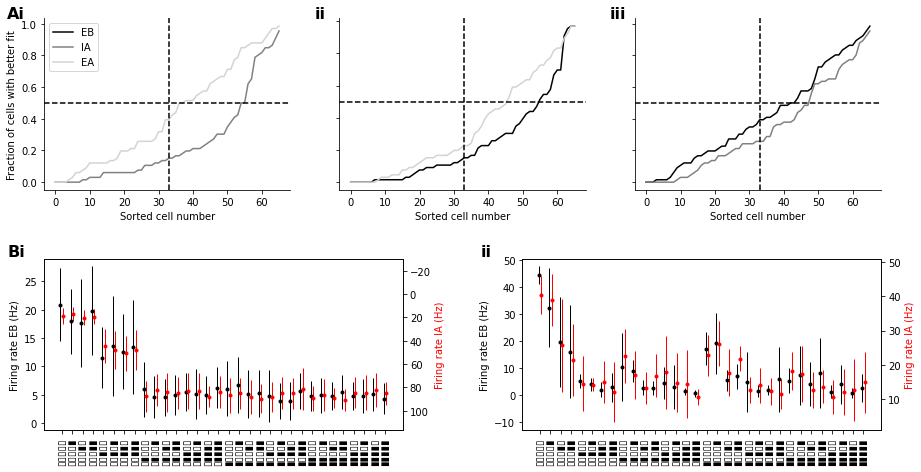

In [18]:
### Plotting

odour_grays = ['k', 'gray', 'lightgray']
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 4, figure=fig, hspace=0.4, wspace=1)

### Making the accuracy axes (part A)
acc_gs = gs[0, :].subgridspec(1, 3)
acc_axs = [fig.add_subplot(i) for i in acc_gs]
acc_axs[0].plot([], color='k', label='EB')

### Plotting the accuracies
ax0, fracs1, sorted_args1 = plot_score_fracs(scores12, scores13, odour1_label='IA', odour2_label='EA', ax=acc_axs[0], colors=[odour_grays[1], odour_grays[2], 'r'], show_best=False)
ax1, fracs2, sorted_args2 = plot_score_fracs(scores21, scores23, odour1_label='EB', odour2_label='EA', ax=acc_axs[1], colors=[odour_grays[0], odour_grays[2], 'r'], show_best=False)
ax2, fracs3, sorted_args3 = plot_score_fracs(scores31, scores32, odour1_label='EB', odour2_label='IA', ax=acc_axs[2], colors=[odour_grays[0], odour_grays[1], 'r'], show_best=False)
[ax.spines['right'].set_visible(False) for ax in acc_axs]
[ax.spines['top'].set_visible(False) for ax in acc_axs]
[i.set_ylabel('') for i in acc_axs[1:]]
[i.set_yticklabels([]) for i in acc_axs[1:]]
acc_axs[0].legend()

### Making the example response plots
best_response_ax1 = fig.add_subplot(gs[1, 0:2])
best_response_ax2 = fig.add_subplot(gs[1, 2:4])

### Plotting them
plot_multi_odour_response2(corr_args[-1], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=best_response_ax1)
plot_multi_odour_response2(corr_args[-8], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=best_response_ax2)

### Labelling the axes
axes = [*acc_axs, best_response_ax1, best_response_ax2]
labels = ['Ai', 'ii', 'iii', 'Bi', 'ii']
align_x = [[0, 3]]
align_y = [[0, 1, 2], [3, 4]]
dx = [0, -0.02, -0.02, 0, 0]
label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', align_x_fun=np.min, align_y_fun=np.max, dx=dx)
#plt.savefig('230703_fig7.pdf', bbox_inches='tight')
